In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


Load Dataset

In [42]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
weather_df = pd.read_csv('dataset/weather_last_cleaned.csv')

In [43]:
pd.set_option("display.max_columns", None)

In [44]:
#Check the data
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [45]:
#Check the data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [46]:
#Change the data type of date column
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

#Create a new column to indicate the year
train_df['Year'] = train_df['Date'].dt.year
test_df['Year'] = test_df['Date'].dt.year

#Create a new column to indicate the month
train_df['Month'] = train_df['Date'].dt.month
test_df['Month'] = test_df['Date'].dt.month

#Create a new column to indicate the week
train_df['Week'] = train_df['Date'].dt.week
test_df['Week'] = test_df['Date'].dt.week

#check the data type again
train_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  Year                    10506 non-null  int64 

In [47]:
#Check the missing value
train_df.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Year                      0
Month                     0
Week                      0
dtype: int64

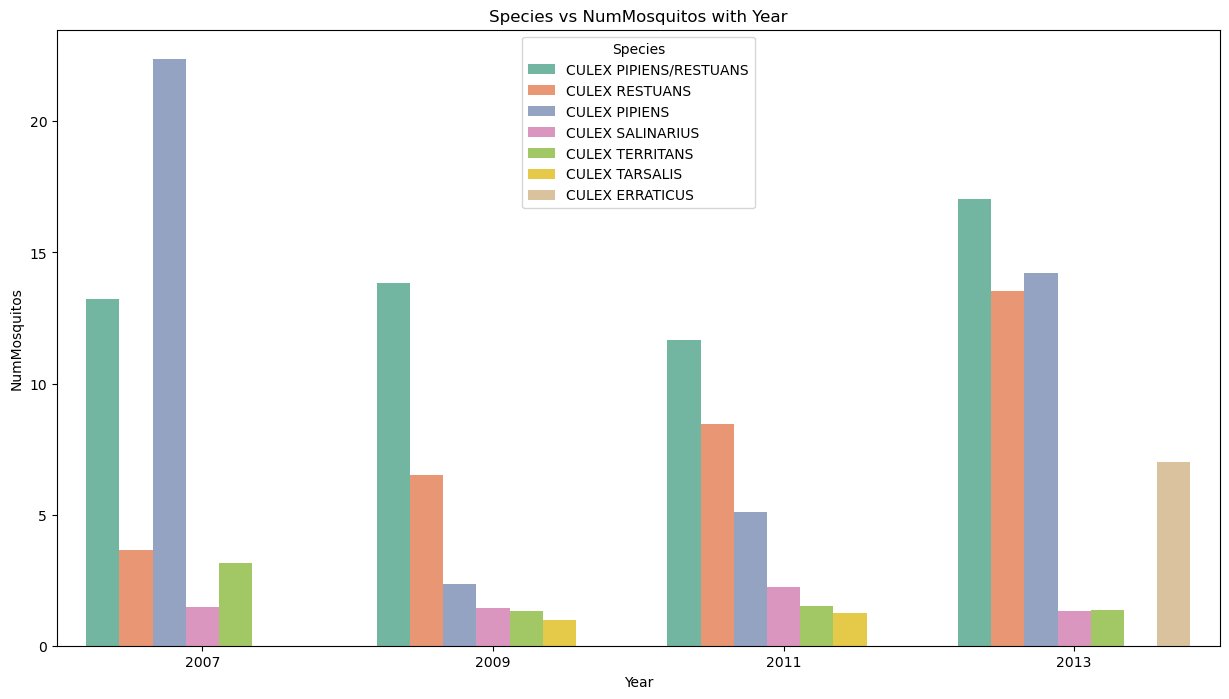

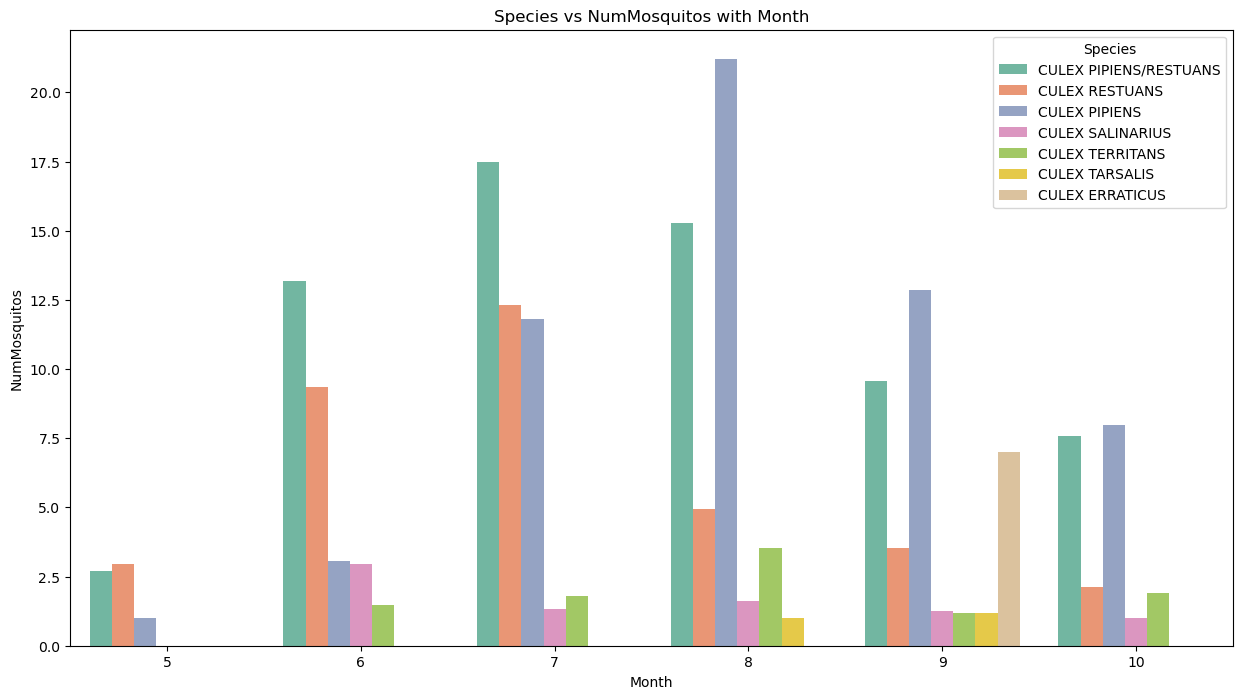

In [48]:
#check Species column with the number of mosquitos and year
train_df.groupby(['Species', 'Year'])['NumMosquitos'].sum()

#visualize the number of mosquitos and year with Species
plt.figure(figsize=(15, 8))
sns.barplot(x='Year', y='NumMosquitos', hue='Species', data=train_df,ci=None, palette='Set2')
plt.title('Species vs NumMosquitos with Year')
plt.show()

#visualize the number of mosquitos and month with Species 
plt.figure(figsize=(15, 8))
sns.barplot(x='Month', y='NumMosquitos', hue='Species', data=train_df,ci=None, palette='Set2')
plt.title('Species vs NumMosquitos with Month')
plt.show()





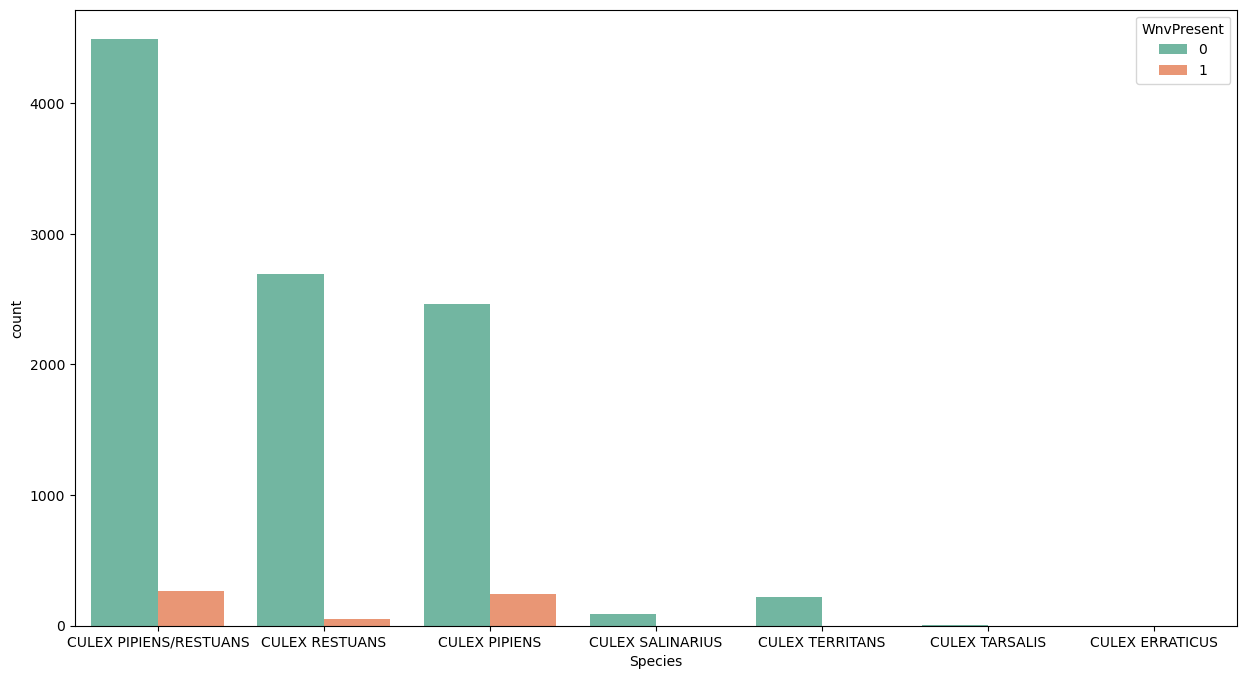

In [49]:
#Check species with WnvPresent = 1 in each year
train_df[train_df['WnvPresent']==1].groupby(['Species', 'Year'])['WnvPresent'].sum()

#visualize the number of WnvPresent and year with Species
plt.figure(figsize=[15,8])
sns.countplot(x="Species", hue=train_df["WnvPresent"], data=train_df, palette='Set2')
plt.show()






In [50]:
#Check shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 15)
(116293, 14)


In [51]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  Year                    10506 non-null  int64 

In [52]:
#Check the number of unique values in each column
train_df.nunique()

Date                       95
Address                   138
Species                     7
Block                      64
Street                    128
Trap                      136
AddressNumberAndStreet    138
Latitude                  138
Longitude                 138
AddressAccuracy             4
NumMosquitos               50
WnvPresent                  2
Year                        4
Month                       6
Week                       20
dtype: int64

In [53]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Week
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22


In [54]:
#Find what latitude and longitude have most WnvPresent = 1
print(train_df[train_df['WnvPresent']==1].groupby(['Latitude', 'Longitude'])['WnvPresent'].sum().sort_values(ascending=False).head(10))

#create a new column to find a distance between the most WnvPresent = 1 and each row
train_df['Distance'] = np.sqrt((train_df['Latitude']-41.974689)**2 + (train_df['Longitude']-(-87.890615))**2)
test_df['Distance'] = np.sqrt((test_df['Latitude']-41.974689)**2 + (test_df['Longitude']-(-87.890615))**2)


Latitude   Longitude 
41.974689  -87.890615    66
41.673408  -87.599862    41
41.954690  -87.800991    18
41.726465  -87.585413    16
41.964242  -87.757639    14
41.944869  -87.832763    11
41.743402  -87.731435    11
41.704572  -87.565666    11
41.957799  -87.930995    10
42.008314  -87.777921    10
Name: WnvPresent, dtype: int64


In [55]:
#Join  train_df and weather_df on Date use only station 1
#also try station 2 but the result is not good
train_df = train_df.merge(weather_df[weather_df['Station']==1], on='Date')
test_df = test_df.merge(weather_df[weather_df['Station']==1], on='Date')




In [56]:
#Check train_df and test_df 
train_df.head()


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Week,Distance,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Rain,Mist,Haze,RH
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,0.091828,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,0.091828,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22,0.123023,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22,0.065806,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22,0.065806,1,88,60,74.0,58.0,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,0,1,1,232.0


In [57]:
#check the shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 37)
(116293, 36)


In [58]:
#Drop columns NumMosquitos because it is not in test_df
train_df.drop(columns='NumMosquitos', inplace=True)

In [59]:
#Check Trap column
train_df['Trap'].value_counts()

#if contain 5 Character remove the last character because it should be 4 character
train_df['Trap'] = train_df['Trap'].apply(lambda x: x[:-1] if len(x)==5 else x)
test_df['Trap'] = test_df['Trap'].apply(lambda x: x[:-1] if len(x)==5 else x)





In [60]:
#Check data type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  WnvPresent              10506 non-null  int64         
 11  Year                    10506 non-null  int64         
 12  Month                   10506 non-null  int64 

In [61]:
#check the shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 36)
(116293, 36)


In [62]:
#Check Address columns
train_df['Address'].value_counts()

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA         750
South Doty Avenue, Chicago, IL, USA                                          542
South Stony Island Avenue, Chicago, IL, USA                                  314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                           185
4200 West 127th Street, Alsip, IL 60803, USA                                 183
                                                                            ... 
3400 West 77th Street, Chicago, IL 60652, USA                                  7
5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA      5
9600 South Longwood Drive, Chicago, IL 60643, USA                              5
2900 West 85th Street, Chicago, IL 60652, USA                                  3
2100 South Hamlin Avenue, Chicago, IL 60623, USA                               2
Name: Address, Length: 138, dtype: int64

In [63]:
#Seperate Address into two columns (Street and City)
train_df['Street'] = train_df['Address'].apply(lambda x: x.split(',')[0])
train_df['City'] = train_df['Address'].apply(lambda x: x.split(',')[1].strip())
test_df['Street'] = test_df['Address'].apply(lambda x: x.split(',')[0])
test_df['City'] = test_df['Address'].apply(lambda x: x.split(',')[1].strip())

In [64]:
#seperate Catagorical and Numerical columns 
cat_cols_train = train_df[['Species', 'Street', 'City', 'Trap',"Rain","Mist","Haze"]]
num_cols_train = train_df[['Latitude', 'Longitude', 'Year', 'Month', 'Distance', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]
cat_cols_test = test_df[['Species', 'Street', 'City', 'Trap',"Rain","Mist","Haze"]]
num_cols_test = test_df[['Latitude', 'Longitude', 'Year', 'Month', 'Distance','Tavg', 'DewPoint', 'WetBulb',  'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]


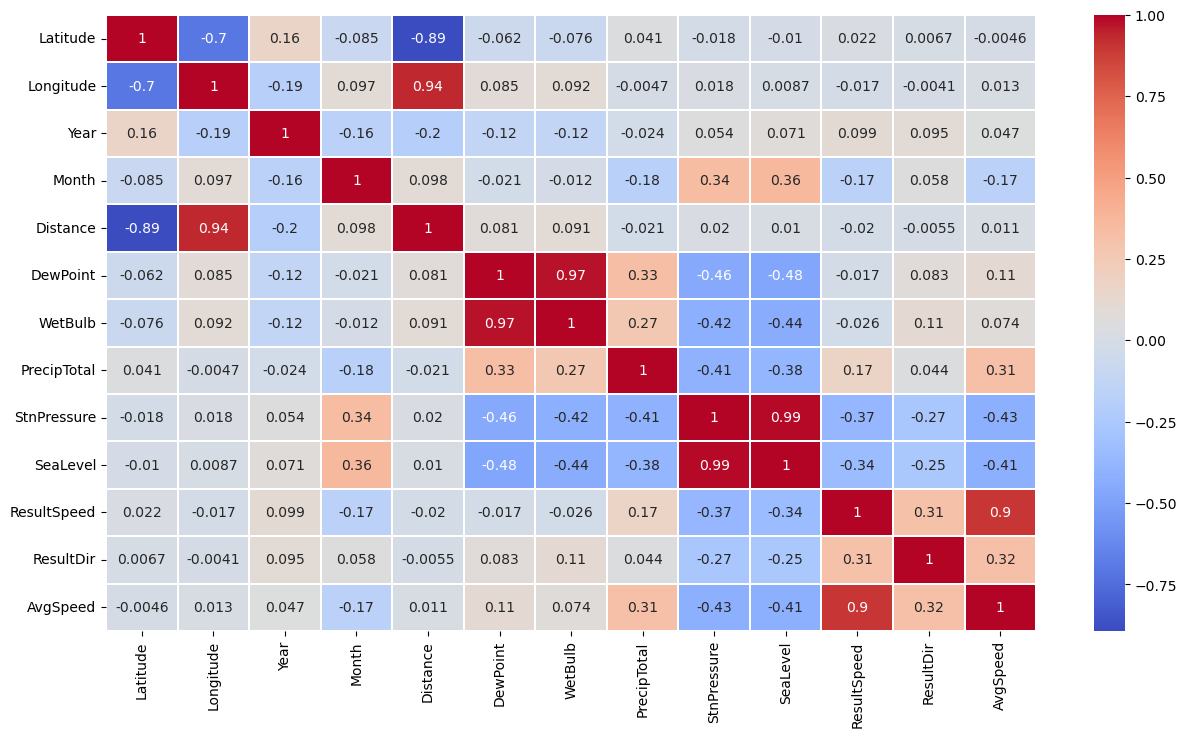

In [84]:
#Check correlation of numeric data 
plt.figure(figsize=(15, 8)) 
sns.heatmap(num_cols_train.corr(), annot=True, cmap='coolwarm', linewidths=0.1, linecolor='white')
plt.show()





In [66]:
#Chage categorical columns to dummy variables
cat_cols_train = pd.get_dummies(cat_cols_train, drop_first=True)
cat_cols_test = pd.get_dummies(cat_cols_test, drop_first=True)

#Concat cat_cols and num_cols
train_model = pd.concat([cat_cols_train, num_cols_train], axis=1)
test_model = pd.concat([cat_cols_test, num_cols_test], axis=1)


#Check the shape of train_df and test_df
print(train_df.shape)
print(test_df.shape)

(10506, 37)
(116293, 37)


In [67]:
#Set X and y
X = train_model
y = train_df['WnvPresent']

In [68]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)



In [69]:
#Check the shape of X_train and X_test
print(X_train.shape)
print(X_test.shape)

(7879, 300)
(2627, 300)


In [70]:
#check the shape of y_train and y_test
print(y_train.shape)
print(y_test.shape)


(7879,)
(2627,)


In [71]:
#Check the value counts of y_train
y_train.value_counts(normalize=True)


0    0.947582
1    0.052418
Name: WnvPresent, dtype: float64

In [72]:
#Use StandardScaler to scale the data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)


#Use SMOTE to balance the data
sm = SMOTE(random_state=42)
X_train_sc_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)
X_test_sc_sm, y_test_sm = sm.fit_resample(X_test_sc, y_test)




In [73]:
#Try with XGBoost Because it is better than RandomforestClassifier
#Use XGBoost with GridSearchCV to find the best parameters
#with Rain, Mist, Haze
xgb = xgb.XGBClassifier()
xgb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3],
    'learning_rate': [0.1, 0.2, 0.3]
}
gs = GridSearchCV(xgb, param_grid=xgb_params, cv=5)
gs.fit(X_train_sc_sm, y_train_sm)
print(gs.best_score_)
print(gs.best_params_)

#Check ROC_AUC score
roc_auc_score(y_test, gs.predict_proba(X_test_sc)[:,1])


0.9608264076234793
{'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 150}


0.8183514711105676

                                importance
Month                             0.218979
Street_South Doty Avenue          0.067410
Mist                              0.055573
Species_CULEX RESTUANS            0.051279
Rain                              0.051218
Year                              0.030228
Species_CULEX PIPIENS/RESTUANS    0.028742
Haze                              0.026356
Street_ORD Terminal 5             0.023688
AvgSpeed                          0.022646


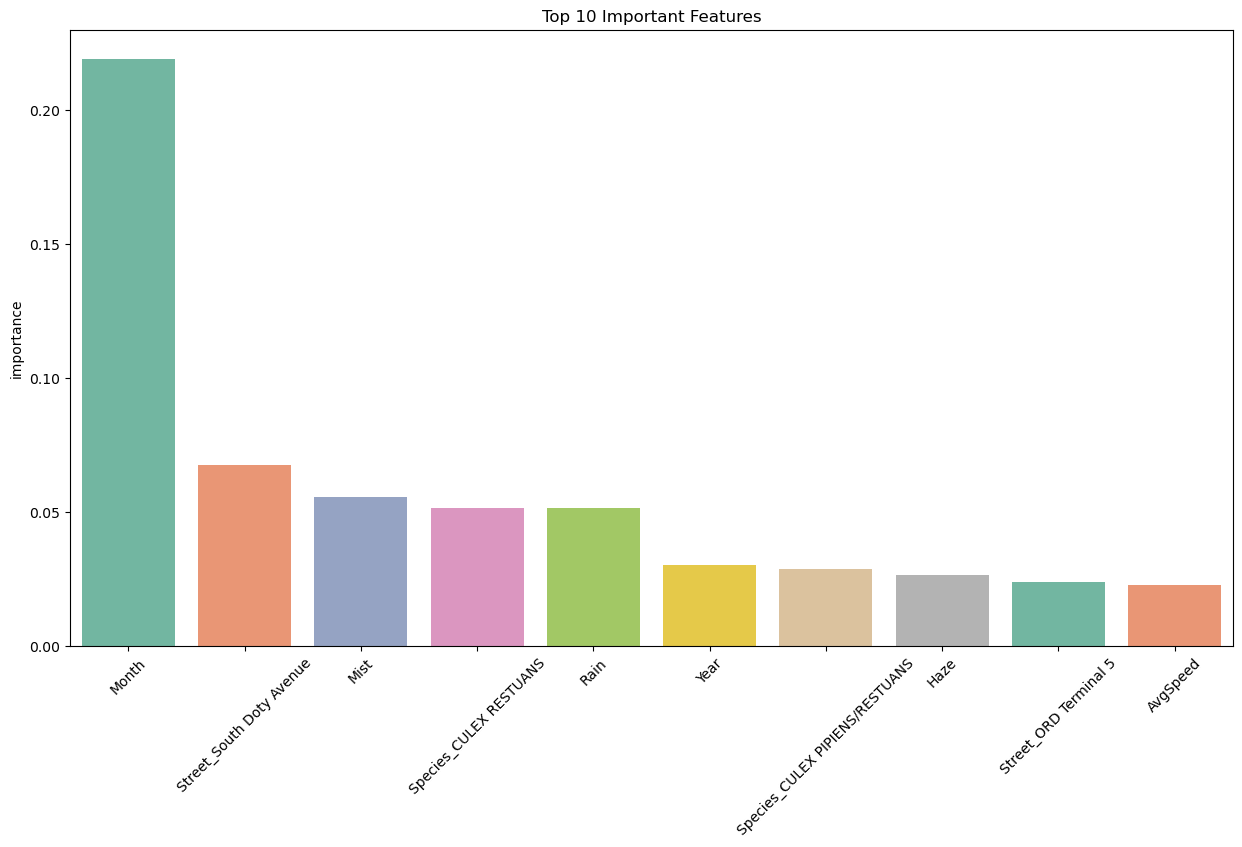

In [74]:
#Find important features predict WnvPresent = 1
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, index=X_train.columns, columns=['importance'])  
print(feat_importance.sort_values(by='importance', ascending=False).head(10))

#Viaualize the important features top 10 in not barplot
plt.figure(figsize=(15, 8))
sns.barplot(x=feat_importance.sort_values(by='importance', ascending=False).head(10).index, y=feat_importance.sort_values(by='importance', ascending=False).head(10)['importance'], palette='Set2')
plt.title('Top 10 Important Features')

plt.xticks(rotation=45)
plt.show()








In [75]:
#check the shape of test_model
print(test_model.shape)


#drop the columns that are not in X_train_sc, X_test_sc
test_model.drop(columns=['Species_UNSPECIFIED CULEX',
'Street_1100 South Loomis Street',
'Street_1200 West 120th Street',
'Street_1400 West 112th Street',
'Street_2600 East 136th Street',
'Street_2900 North Kenneth Avenue',
'Street_3400 North Long Avenue',
'Street_3700 North Kilbourn Avenue',
'Street_4000 North Kedvale Avenue',
'Street_4600 North Melvina Avenue',
'Street_5100 West 63rd Place',
'Street_6500 West Dakin Street',
'Street_South Baltimore Avenue',
'Street_South Oglesby Avenue',
'Trap_T234'], inplace=True)



#Check the shape of test_model after drop columns
print(test_model.shape)

(116293, 315)
(116293, 300)


In [77]:
test_model_sc = ss.transform(test_model)

#predict the test_model
pred = gs.predict_proba(test_model_sc)[:,1]

#submit the result
submission = pd.DataFrame({'Id': test_df['Id'], 'WnvPresent': pred})

#save the submission to csv
submission.to_csv('submission_gb_rain_dew.csv', index=False)
